# Machine Learning Project 1

### 518021910862 刘遇时

## Read and split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

1. Read the original data:

In [2]:
data = pd.read_csv("train.csv")
data

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


2. Split the data into 3 parts:

In [3]:
price_train_data = data.truncate(before=0, after=1599)
price_valid_data = data.truncate(before=1600, after=1799)
price_test_data = data.truncate(before=1800, after=1999)

## Naive Bayesian 

1. Data preprocessing

According to our observation, 4 attributes need to be discretized: battery_power, px_height, px_width, ram. Accroding to our material, the problem is tranformed to a 2-class Classification problem. Naive Bayesian Classification do not need a valid testset: since it's not suffered from the problem of overfitting.

In [4]:
def NB_preprocess(x):
    x['battery_power'] = x['battery_power'].map(lambda x: x//40)
    x['px_height'] = x['px_height'].map(lambda x: x//40)
    x['px_width'] = x['px_width'].map(lambda x: x//40)
    x['ram'] = x['ram'].map(lambda x: x//80)
    x['price_range'] = x['price_range'].map(lambda x: x//2)
    return x
NB_train_data = NB_preprocess(pd.concat([price_train_data, price_valid_data]))

2. Model Implementation

In [5]:
def NB_train(train):
    prior = train['price_range'].value_counts(normalize=True)
    phone0 = train.loc[lambda train: train['price_range'] == 0]
    phone1 = train.loc[lambda train: train['price_range'] == 1]
    
    cond0 = pd.DataFrame(columns=phone0.columns)
    attr_kind0 = pd.Series(index=phone0.columns, dtype=np.int)
    for attribute,row in phone0.iteritems():
        if attribute == 'price_range':
            break
        row_percentage = row.value_counts(normalize=True)
        for num,value in row_percentage.items():
            cond0.loc[num, attribute] = value
        attr_kind0.loc[attribute] = len(row.value_counts())
    cond0 = cond0.fillna(0)
    
    cond1 = pd.DataFrame(columns=phone1.columns)
    attr_kind1 = pd.Series(index=phone1.columns, dtype=np.int)
    for attribute,row in phone1.iteritems():
        if attribute == 'price_range':
            break
        row_percentage = row.value_counts(normalize=True)
        for num,value in row_percentage.items():
            cond1.loc[num, attribute] = value
        attr_kind1.loc[attribute] = len(row.value_counts())
    cond1 = cond1.fillna(0)
    return (prior, cond0, cond1, attr_kind0, attr_kind1)
start_time = time.time()
(NB_prior, NB_cond0, NB_cond1, NB_attr_kind0, NB_attr_kind1) = NB_train(NB_train_data)

3. Predict!

In [6]:
def NB_predict(data, prior, cond0, cond1, attr_kind0, attr_kind1):
    data.loc['battery_power'] = data.loc['battery_power'] // 40
    data.loc['px_height'] = data.loc['px_height'] // 40
    data.loc['px_width'] = data.loc['px_width'] // 40
    data.loc['ram'] = data.loc['ram'] // 80
    cnt0 = 2000*prior[0]
    cnt1 = 2000*prior[1]
    possibility0 = math.log(prior[0])
    for attribute,value in data.items():
        if attribute == 'price_range':
            break
        ret = cond0.loc[value, attribute]
        if ret == 0:
            possibility0 -= math.log(1800+attr_kind0[attribute])
        else:
            possibility0 += math.log(ret)
    possibility1 = math.log(prior[1])
    for attribute,value in data.items():
        if attribute == 'price_range':
            break
        ret = cond1.loc[value, attribute]
        if ret == 0:
            possibility1 -= math.log(1800+attr_kind1[attribute])
        else:
            possibility1 += math.log(ret)
    if possibility0 > possibility1:
        return 0
    else:
        return 1
total = len(NB_train_data.index)
correct = 0
train_set = pd.concat([price_train_data, price_valid_data])
for index,data in train_set.iterrows():
    predict = NB_predict(data, NB_prior, NB_cond0, NB_cond1, NB_attr_kind0, NB_attr_kind1)
    if predict == data['price_range'] // 2:
        correct += 1
NB_train_correction_rate = correct/total
print('Training Set Correction Rate: {:.2%}'.format(NB_train_correction_rate))
total = len(price_test_data.index)
correct = 0
for index,data in price_test_data.iterrows():
    predict = NB_predict(data, NB_prior, NB_cond0, NB_cond1, NB_attr_kind0, NB_attr_kind1)
    if predict == (data['price_range'] // 2):
        correct = correct + 1
NB_test_correction_rate = correct/total
print('Test Set Correction Rate: {:.2%}'.format(NB_test_correction_rate))
end_time = time.time()
NB_time = end_time - start_time
print('Time: %f second' % NB_time)

Training Set Correction Rate: 95.06%
Test Set Correction Rate: 92.50%
Time: 2.702353 second


## Logistic Regression

1. Data Preprocessing

Key point is to normalization.

In [7]:
def LR_preprocess(x):
    for attribute,value in x.iteritems():
        if attribute == 'price_range':
            break
        x[attribute] = (x[attribute]-x[attribute].min())/(x[attribute].max()-x[attribute].min())
    x['price_range'] = x['price_range'].map(lambda x: x//2)
    x['0'] = 1
    return x
LR_data = LR_preprocess(pd.concat([price_train_data, price_valid_data, price_test_data]))
LR_train_data = LR_data.truncate(before=0, after=1799)
LR_test_data = LR_data.truncate(before=1800, after=1999)

2. Model Implementation

Using Gradient Descent approach. Each iteration choose 10% of data as validation set, choose model according to correction rate of validation set.

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def LR_GD(training):
    w = pd.Series(index=training.columns, dtype=np.double)
    delta_w = pd.Series(index=training.columns, dtype=np.double)
    w_final = pd.Series(index=training.columns, dtype=np.double)
    for attribute,value in w.items():
        if attribute == 'price_range':
            continue
        w.loc[attribute] = 0
    step = 1
    correction_rate = 0
    for num in range(20):
        train = training.sample(n=1600)
        valid = training.sample(n=200)
        total = len(valid.index)
        for attribute,value in delta_w.items():
            delta_w.loc[attribute] = 0
        loss = 0
        for index,data in train.iterrows():
            a = 0
            for attribute,value in data.items():
                if attribute == 'price_range':
                    continue
                a += w[attribute] * value
            y = sigmoid(a)
            r = data.loc['price_range']
            delta_w += (r-y)/1600*data
            loss -= (r*math.log(y)+(1-r)*math.log(1-y))
        w += step*delta_w
        correct = 0
        for index,data in valid.iterrows():
            predict = LR_predict(data, w)
            if predict == data['price_range']:
                correct = correct + 1
        if correct/total > correction_rate:
            correction_rate = correct/total
            w_final = w
    return w_final
def LR_predict(data, w):
    ans = 0
    for attribute,value in data.items():
        if (attribute == 'price_range') | (attribute == '0'):
            continue
        ans += value * w.loc[attribute]
    ans += w.loc['0']
    if ans < 0:
        return 0
    else:
        return 1
def LR_train(train):
    return LR_GD(train)
start_time = time.time()
w = LR_train(LR_train_data)

3. Predict!

In [9]:
correct = 0
total = len(LR_train_data.index)
for index,data in LR_train_data.iterrows():
    predict = LR_predict(data, w)
    if predict == data['price_range']:
        correct = correct + 1
LR_train_correction_rate = correct/total
print('Training Set Correction Rate: {:.2%}'.format(LR_train_correction_rate))
correct = 0
total = len(LR_test_data.index)
for index,data in LR_test_data.iterrows():
    predict = LR_predict(data, w)
    if predict == data['price_range']:
        correct = correct + 1
LR_test_correction_rate = correct/total
print('Test Set Correction Rate: {:.2%}'.format(LR_test_correction_rate))
end_time = time.time()
LR_time = end_time - start_time
print('Time: %f second' % LR_time)

Training Set Correction Rate: 90.61%
Test Set Correction Rate: 91.00%
Time: 27.831986 second


## Support Vector Machine

1. Model Implementation & Predict!

Use SVM in sklearn package.

In [10]:
from sklearn import svm
def SVM_train(train, test):    
    clf = svm.SVC()
    clf.fit(train.drop(columns=['price_range']), train['price_range'])
    train_score = clf.score(train.drop(columns=['price_range']), train['price_range'])
    test_score = clf.score(test.drop(columns=['price_range']), test['price_range'])
    return (train_score, test_score)
SVM_train_data = pd.concat([price_train_data, price_valid_data])
SVM_test_data = price_test_data
SVM_train_data['price_range'] = SVM_train_data['price_range'].map(lambda x: x//2)
SVM_test_data['price_range'] = SVM_test_data['price_range'].map(lambda x: x//2)
start_time = time.time()
(SVM_train_correction_rate, SVM_test_correction_rate) = SVM_train(SVM_train_data, SVM_test_data)
print('Training Set Correction Rate: {:.2%}'.format(SVM_train_correction_rate))
print('Test Set Correction Rate: {:.2%}'.format(SVM_test_correction_rate))
end_time = time.time()
SVM_time = end_time - start_time
print('Time: %f second' % SVM_time)

Training Set Correction Rate: 98.56%
Test Set Correction Rate: 98.50%
Time: 0.060309 second


## Performance Analysis

1. Accuracy

In [11]:
accuracy_data = {
    'Naive Bayesian':[NB_train_correction_rate, NB_test_correction_rate],
    'Logistic Regression':[LR_train_correction_rate, LR_test_correction_rate],
    'Support Vector Machine':[SVM_train_correction_rate, SVM_test_correction_rate]
}
accuracy = pd.DataFrame(accuracy_data, index=['training set','test set'], columns=['Naive Bayesian','Logistic Regression','Support Vector Machine'])
accuracy

,Naive Bayesian,Logistic Regression,Support Vector Machine
training set,0.950556,0.906111,0.985556
test set,0.925000,0.910000,0.985000


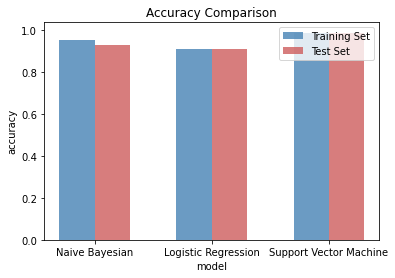

In [12]:
x_data = ['Naive Bayesian', 'Logistic Regression', 'Support Vector Machine']
y_data = [NB_train_correction_rate, LR_train_correction_rate, SVM_train_correction_rate]
y_data2 = [NB_test_correction_rate, LR_test_correction_rate, SVM_test_correction_rate]
bar_width = 0.3
plt.bar(x=range(len(x_data)), height=y_data, label='Training Set',
    color='steelblue', alpha=0.8, width=bar_width)
plt.bar(x=np.arange(len(x_data))+bar_width, height=y_data2,
    label='Test Set', color='indianred', alpha=0.8, width=bar_width)
plt.title('Accuracy Comparison')
plt.xticks(np.arange(len(x_data))+bar_width/2, x_data)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.legend()
plt.show()

According to the result, the SVM model from sklearn package has the best performance in accuracy, while the NB and LR model both has accuracy about 90%.

Consider the fact that NB and LR model is written from scratch, the result is acceptable.

2. Time

In [13]:
time_data = {
    'Naive Bayesian': NB_time,
    'Logistic Regression': LR_time,
    'Support Vector Machine': SVM_time
}
time_table = pd.DataFrame(time_data, index=['time'], columns=['Naive Bayesian','Logistic Regression','Support Vector Machine'])
time_table

,Naive Bayesian,Logistic Regression,Support Vector Machine
time,2.702353,27.831986,0.060309


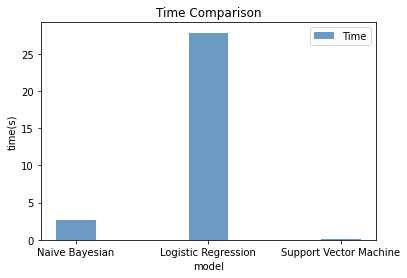

In [14]:
x_data = ['Naive Bayesian', 'Logistic Regression', 'Support Vector Machine']
y_data = [NB_time, LR_time, SVM_time]
bar_width = 0.3
plt.bar(x=range(len(x_data)), height=y_data, label='Time',
    color='steelblue', alpha=0.8, width=bar_width)
plt.title('Time Comparison')
plt.xticks(np.arange(len(x_data)), x_data)
plt.xlabel('model')
plt.ylabel('time(s)')
plt.legend()
plt.show()

The result indicates a significant performance difference between models.

SVM from sklearn package needs about 0.1s , while my LR from scratch runs very slowly....

## Summary

1. Naive Bayesian

NB model is easy for implementation and prediction, and has both accuracy and timing performance in the middle of 3. Consider the fact that it's easy enough in theory, but often has relatively good accuracy while running fast,  when facing situations where you need to deal with massive amount of data, it's worth a try. 

2. Logistic Regression

LR model has acceptable accuracy(perhaps better when increase the number of iterations), but it's suffered from worst timing performance. In my implementaion, I choose the original gradient descent approach, which use the whole dataset to calculate gradient(delta_w) each iteration. If switching to MiniBatch or Adam, it may have better timing performance.

3. Support Vector Machine

SVM model has the best accuracy and shortest running time amoung 3 models. More importantly, due to theoretical support (choose the minimum functional margin among vectors), SVM tend to avoid the problem of over-fitting.